Completo de comentarios

Using TensorFlow backend.


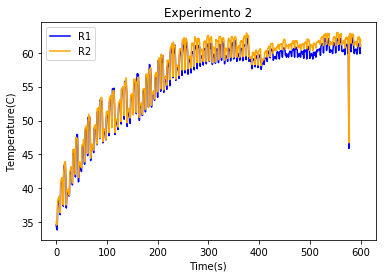

In [1]:
import csv
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pandas import DataFrame
from keras import optimizers
from keras import losses
from keras.utils.np_utils import to_categorical
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.models import load_model, Model, Sequential
from keras.layers import Input, LSTM, SimpleRNN, GRU, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error,explained_variance_score 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import math
from math import sqrt, floor
import h5py
from StringIO import StringIO 
import requests
from datetime import datetime


#datos calefactor
r = requests.get('https://docs.google.com/spreadsheets/d/1ergnEntvt_zxCwXKH0Tq2wAfciUzzwrPEfLmWaKeU8s/export?format=csv&id=1ergnEntvt_zxCwXKH0Tq2wAfciUzzwrPEfLmWaKeU8s')

#datos no calefactor
#r = requests.get('https://docs.google.com/spreadsheets/d/1dT8BLL4T_MaSi7YUrF8mP6lgHhQdsFxiVEYySjLdraM/export?format=csv&id=1dT8BLL4T_MaSi7YUrF8mP6lgHhQdsFxiVEYySjLdraM')

data=r.content
#de csv a array
dataset = pd.read_csv(StringIO(data), header=0).values
#https://docs.google.com/spreadsheets/d/<KEY>/export?format=csv&id=<KEY>  FORMATO PARA GOOGLE DRIVE

plt.plot(dataset[:,0], color='blue', label='R1')
plt.plot(dataset[:,1], color='orange', label='R2')
plt.xlabel('Time(s)')
plt.ylabel('Temperature(C)')
plt.title('Experimento 2')
plt.legend()
plt.show()

In [2]:

#definimos parametros
batch_size=10
timesteps=1
#obtener tamaño de train y test en funcion del tamaño de batch que queramos
length=len(dataset)
print(length)
min_trainset=int(floor(length*0.85))
max_trainset=int(floor(length*0.9))
max_testset= int(floor(length*0.15))
min_testset=int(floor(length*0.1))
                 
def set_sizes(min_trainset,max_trainset,min_testset,max_testset,length,batch_size):
    train_val=[]
    test_val=[]
    batch_val=[]
    for x in range(min_trainset,max_trainset): # train set
        for y in range(min_testset,max_testset): #test set
            comb=x+y
            if(comb<(length-(timesteps*2)) and comb>min_trainset):   
                modulo=x%batch_size
                modulo2=y%batch_size
                if  (modulo==0) and (modulo2==0):
                    train_val.append(x)
                    test_val.append(y)
    
    return (train_val,test_val)

train,test = set_sizes(min_trainset,max_trainset,min_testset,max_testset ,length, batch_size)

#esto depende de lo que queramos y del caso:
for i in range (len(train)):
    if train[i]==max(train):
        test=test[i]
        train=train[i]

length_train=train#esto es lo que queremos tener, aunque usemos mas datos el tamaño sera (length_train,10)
length_test=test #lo mismo


#Adding timesteps * 2..para las agrupaciones posteriores
upper_train=length_train+timesteps*2
upper_test=length_test+timesteps*2
print(length_train, length_test,length_train+length_test)
print(upper_train,upper_test,upper_train+upper_test)

# split data into train and test [filas(:),columnas(:)]
train, test = dataset[:upper_train,], dataset[upper_train:upper_train+upper_test,]  
print(train.shape, test.shape)

601
(530, 60, 590)
(532, 62, 594)
((532, 10), (62, 10))


In [3]:


#escalado columna a columna con sus desv y medias individuales (train)
train_scaled= np.zeros(shape=(len(train), 10))
#escalado columna a columna con sus desv y medias individuales (test)
test_scaled= np.zeros(shape=(len(test), 10))


# para que al reescalar la solucion usemos la misma media y varianza que en la que tenemos en la temperatura del train
#que es la columna 0, hacemos el for invertido
for i in range (0,10):
    i=9-i
    scaler=StandardScaler(with_mean=True, with_std=True)
    #train  
    train_0=train[:,i]   
    train_0 = train_0.reshape(train_0.shape[0], 1)   
    scaler = scaler.fit(train_0)    
    train_0=scaler.transform(train_0)
    train_scaled[:,i]=train_0[:,0] #se va haciendo columna a columna, por eso solo hay una columna
    #test (no fit porque no sabes que vas a tener en el futuro osea que se usa el de train)
    test_0=test[:,i]
    test_0 = test_0.reshape(test_0.shape[0], 1)
    test_0=scaler.transform(test_0)   
    test_scaled[:,i]=test_0[:,0]

#to forecast time-series necesitamos agrupar los datos etc
x_test=[]    #etiqueta entrenamiento
x_train= np.zeros(shape=(length_train,timesteps,10))   #datos entrenamiento
y_train=np.zeros(shape=(length_test,timesteps,10))   #datos test
y_test=[] #etiqueta test
x_train_plot=[]


########dependiendo de la raspi a predecir se cambian las siguientes lineas###################################################################################
#x_test.append(train_scaled[i-1:i+timesteps-1,0]) 0 o 1 al final
#y_test.append(test_scaled[i-1:i+timesteps-1,0])

for i in range(timesteps, length_train+timesteps): 
    x_train[i-timesteps:i,]=train_scaled[i-timesteps:i,]  
    x_test.append(train_scaled[i-1:i+timesteps-1,1])     #preguntar, pero si no se pone el -uno no estás prediciendo los dos datos siguientes sino los siguientes,
    #por lo que sería los segundos 30 y 40 en vez de 10 y 20

for i in range(timesteps, length_test+timesteps):    
    y_train[i-timesteps:i,]=test_scaled[i-timesteps:i,]
    y_test.append(test_scaled[i-1:i+timesteps-1,1]) #lo mismo que antes


#para pasar de lista a np array los test
x_test=np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1)) 
y_test =np.array(y_test)
y_test = np.reshape(y_test, (y_test.shape[0],y_test.shape[1] ,1))


print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

((530, 1, 10), (530, 1, 1))
((60, 1, 10), (60, 1, 1))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (10, 1, 30)               4920      
_________________________________________________________________
lstm_2 (LSTM)                (10, 1, 15)               2760      
_________________________________________________________________
dense_1 (Dense)              (10, 1, 1)                16        
Total params: 7,696
Trainable params: 7,696
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
0:00:47.501995
299) TrainRMSE=0.036628, TestRMSE=0.075333


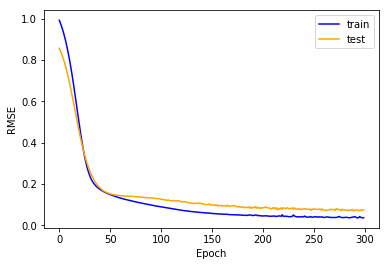

In [4]:
nb_epoch=300
neurons=30
learn_rate=0.0001
#momentum=0.1
#def model(x_train, x_test, batch_size, nb_epoch, neurons):       
#input=(batch,timestep,hidden size)
opt = optimizers.Adam(lr=learn_rate)
model = Sequential()
model.add(LSTM(neurons,return_sequences=True, dropout=0, batch_input_shape=(batch_size, x_train.shape[1], x_train.shape[2]) , stateful=False))
model.add(LSTM(15,return_sequences=True,dropout=0.1, stateful=False))
#model.add(GRU(5,return_sequences=True,dropout=0.4 , stateful=False))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])

print(model.summary())
train_rmse, test_rmse = [],[]

#start time
tstart = datetime.now()

for i in range(nb_epoch):
    model.fit(x_train, x_test, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    #model.reset_states()   
    # evaluate model on train data    
    output=model.predict(x_train, batch_size=batch_size)
    output=output.flatten()
    x_test1=x_test.flatten()
    rmse = sqrt(mean_squared_error(x_test1, output))
    train_rmse=np.append(train_rmse,rmse)
		  
    # evaluate model on test data    
    output1=model.predict(y_train, batch_size=batch_size)
    output1_flat=output1.flatten()        
    y_test1 = y_test.flatten()
    rmse1 = sqrt(mean_squared_error(y_test1, output1_flat)) 
    test_rmse=np.append(test_rmse,rmse1)
#end time
tend = datetime.now()
print (tend-tstart)

history = pd.DataFrame()
history['train'], history['test'] = train_rmse, test_rmse
plt.plot(history['train'], color='blue', label='train')
plt.plot(history['test'], color='orange', label='test')
print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))	
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()      

In [5]:
#para hacer la inversa del escalado tiene que tener este formato:(,) (StandardScaler)


output1=np.reshape(output1,(output1.shape[0], output1.shape[1]))
prediction_inverse= scaler.inverse_transform(output1)
test_inverse=scaler.inverse_transform(y_test)
print(prediction_inverse.shape)

#separamos los datos de los timesteps, para que tengan el mismo formato que cuando lo escalamos
test_prediction = []
y_test_sep=[]
for i in range(0, length_test-timesteps):
    test_prediction = np.append(test_prediction, prediction_inverse[i, timesteps-1]) #aqui se queda con formato (x,)
    y_test_sep= np.append(y_test_sep, test_inverse[i,timesteps-1])

print(test_prediction.shape)
print(y_test_sep.shape)

(60, 1)
(59,)
(59,)


R2: 0.943
R2_explained: 0.974
MAE: 0.413
Median_AE: 0.452
RMSE: 0.479
MSLE: 0.000


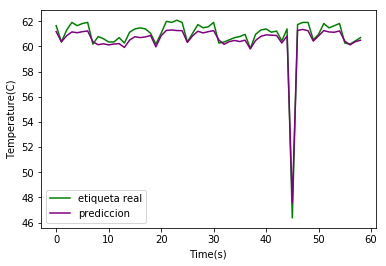

In [6]:
#vamos a validarlo con las metricas que propone keras para regresión+ error máximo
R2=r2_score(y_test_sep, test_prediction) 
R2_explained=explained_variance_score(y_test_sep, test_prediction)
MAE=mean_absolute_error(y_test_sep, test_prediction)
Median_AE=median_absolute_error(y_test_sep, test_prediction)
RMSE = sqrt(mean_squared_error(y_test_sep, test_prediction))
MSLE=mean_squared_log_error(y_test_sep, test_prediction)

print('R2: %.3f' % R2)
print('R2_explained: %.3f' % R2_explained)
print('MAE: %.3f' % MAE)
print('Median_AE: %.3f' % Median_AE)
print('RMSE: %.3f' % RMSE)
print('MSLE: %.3f' % MSLE)

#visualizar resultados 
plt.plot(y_test_sep, color='green', label='etiqueta real')
plt.plot(test_prediction, color='purple', label='prediccion')
#plt.plot(x_train_plot1,color='pink', label='tiempo real')
plt.xlabel('Time(s)')
plt.ylabel('Temperature(C)')
plt.legend()
plt.show()